In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

import torch
from torch.distributions import Categorical

from model import *
from utils import visualize_MAML

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Model Agnostic Meta Learning

## Training

In [5]:
net  = HumanResponseNet(input_size=5, hidden_size=32, output_size=2, dropout_rate=0)
maml = HumanResponseMAML(net, alpha=0.01, beta=0.001, K=32, num_meta_tasks=1000, device=device)

In [6]:
maml.outer_loop(num_epochs=100) # 16~31 mins for processing

model_weights_path = "meta_HumanResponseNet.pth"
torch.save(net.state_dict(), model_weights_path)

Epoch 100 completed


In [10]:
net_supervised = HumanResponseNet(input_size=5, hidden_size=32, output_size=2, dropout_rate=0)
net_supervised = train_supervised(subject_id=5, sample_size=32, num_epochs=100, batch_size=32, net_supervised=net_supervised, device=device)
net_meta_supervised = train_supervised(subject_id=5, sample_size=32, num_epochs=100, batch_size=32, net_supervised=net_supervised, pretrained_pth_path="meta_HumanResponseNet.pth", device=device)

Epoch [10/100], Loss: 6.6100
Epoch [20/100], Loss: 3.3229
Epoch [30/100], Loss: 2.5325
Epoch [40/100], Loss: 2.2523
Epoch [50/100], Loss: 1.9899
Epoch [60/100], Loss: 1.7664
Epoch [70/100], Loss: 1.5896
Epoch [80/100], Loss: 1.4423
Epoch [90/100], Loss: 1.3136
Epoch [100/100], Loss: 1.2026
Epoch [10/100], Loss: 13.5215
Epoch [20/100], Loss: 5.9268
Epoch [30/100], Loss: 2.3484
Epoch [40/100], Loss: 2.2356
Epoch [50/100], Loss: 1.2772
Epoch [60/100], Loss: 0.8488
Epoch [70/100], Loss: 0.7565
Epoch [80/100], Loss: 0.6823
Epoch [90/100], Loss: 0.6096
Epoch [100/100], Loss: 0.5605


### Visualization

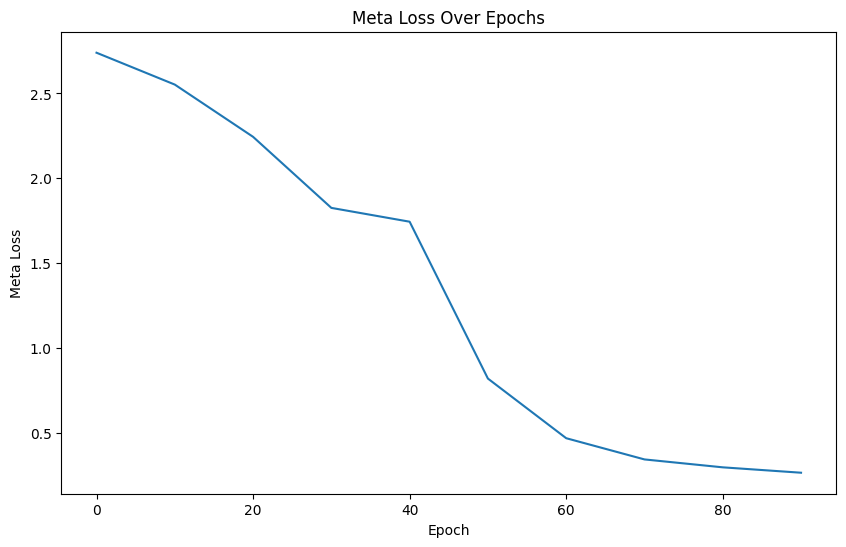

In [11]:
x_values = np.arange(0, len(maml.meta_losses) * 10, 10)  # 10 comes from plot_every

plt.figure(figsize=(10, 6))
plt.plot(x_values, maml.meta_losses)
plt.title("Meta Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Meta Loss")
plt.show()

In [13]:
net_meta_supervised == net_supervised

True

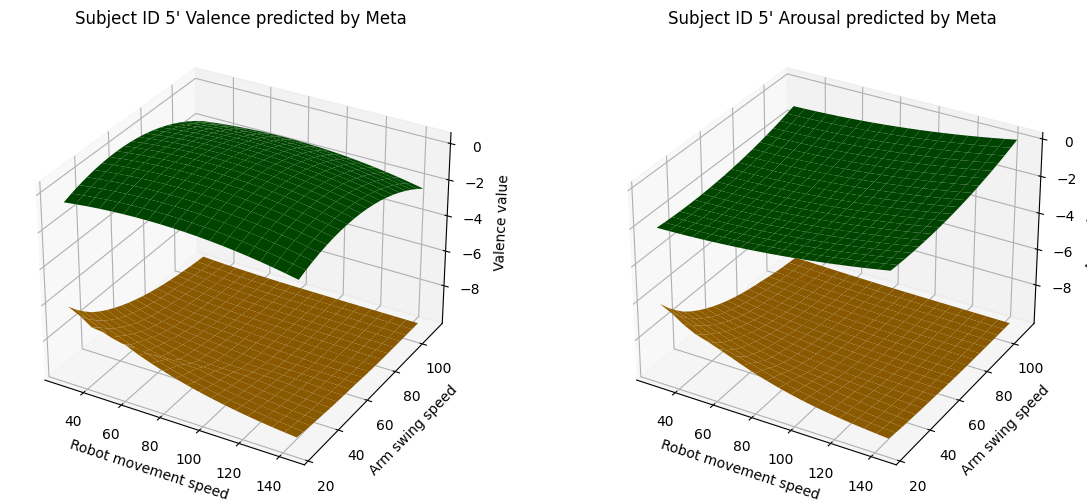

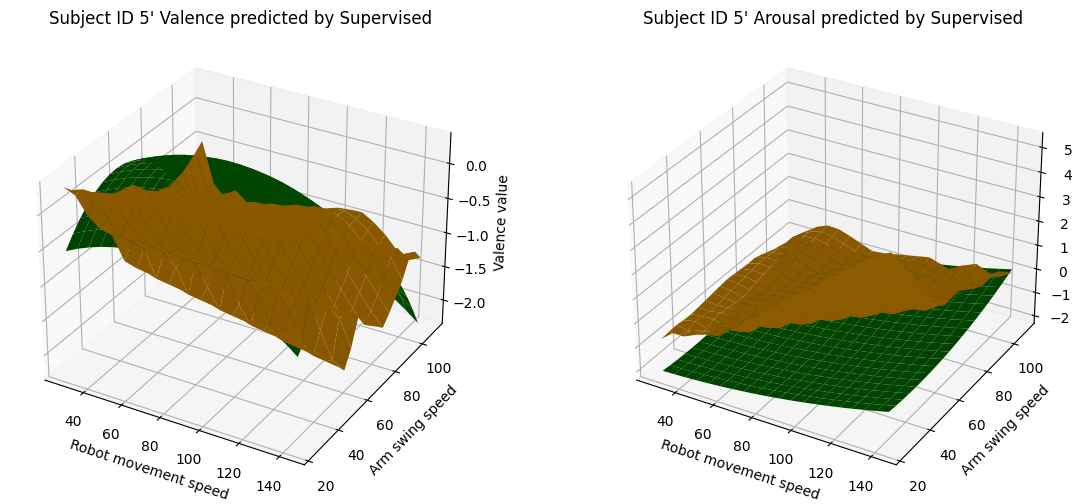

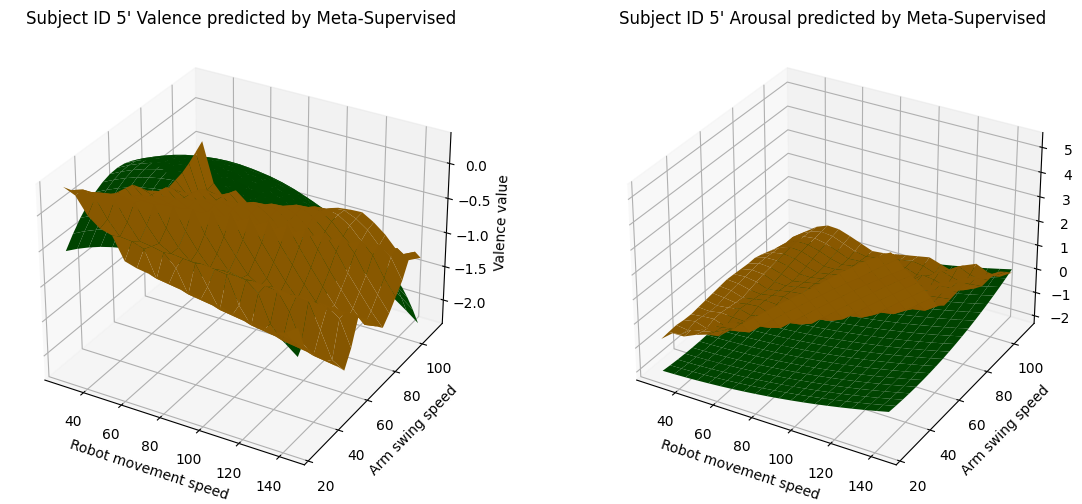

In [12]:
visualize_MAML(maml.net, seed=3, net_name="Meta", device=device)
visualize_MAML(net_supervised, seed=3, net_name="Supervised", device=device)
visualize_MAML(net_meta_supervised, seed=3, net_name="Meta-Supervised", device=device)

# Continous Action Space Proximal Policy Optimization (PPO)

In [2]:
hr_net = HumanResponseNet(input_size=5, hidden_size=32, output_size=2, dropout_rate=0)
hr_net.load_state_dict(torch.load("supervised_HumanResponseNet.pth"))
# hr_net.load_state_dict(torch.load("meta_HumanResponseNet.pth"))
hr_net.to(device)

HumanResponseNet(
  (linear1): Linear(in_features=5, out_features=32, bias=True)
  (dropout1): Dropout(p=0, inplace=False)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (dropout2): Dropout(p=0, inplace=False)
  (linear3): Linear(in_features=32, out_features=2, bias=True)
)

## Continous Action Space PPO  

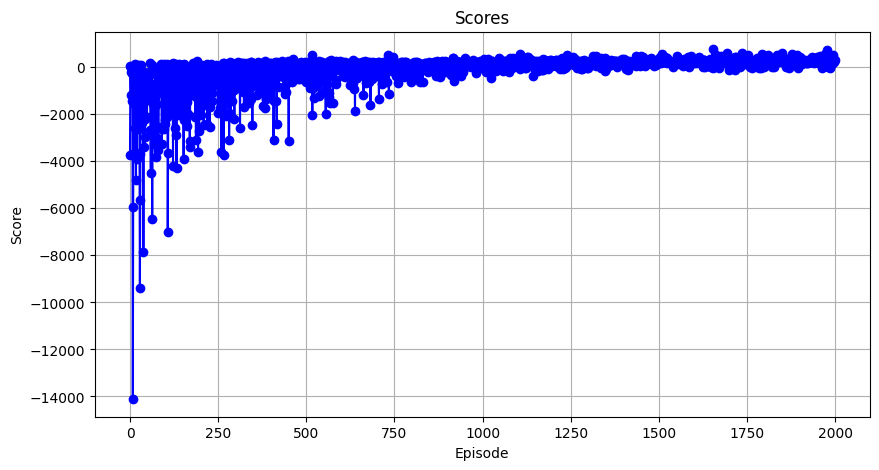

In [8]:
env = HRCENV(hr_net=hr_net, move_distance=305, arm_distance=120, penalty_standard=(271, 0, 0), penalty=200)
ppo = PPO(state_dim=3, hidden_dim=128, action_dim=5, std=0.1, learning_rate=3e-3,
          K_epochs=3, gamma=0.98, lmbda=0.95, eps_clip=0.1, device=device,
          )

#TODO: Please check a terminate condition
terminate_condition = (271,70,0,0)
terminate_prob = 0.01

num_episodes = 2000
T_horizon    = 20

score = 0.0
print_interval = 1
average_scores = []
for n_epi in range(num_episodes):
    s = env.reset()
    done = False

    while not done:
        for t in range(T_horizon):
            s_old = s.clone()
            
            dist_1, dist_2, action_1, action_2, bin_actions, log_prob_1, log_prob_2, bin_probs = ppo.AC.sample(s.to(device))
            log_prob = log_prob_1 + log_prob_2 + torch.sum(torch.log(bin_probs))
            
            move_speed = scale_action(action_1, env.move_speed_boundary[0], env.move_speed_boundary[1])
            arm_speed  = scale_action(action_2, env.arm_speed_boundary[0], env.arm_speed_boundary[1])
            action = torch.cat((torch.tensor([move_speed, arm_speed]).to(device), bin_actions)) # action = modified_robot_state
            s_prime, r, done = env.step(action, terminate_condition=terminate_condition)
            
            ppo.put_data((s_old.to(device), action, r/100.0, s_prime, log_prob.item(), done))
            s = s_prime
            score += r
            # print("Move speed: %.2f   Arm speed: %.2f    binary actions %d %d %d    productivity: %.2f   valence: %.1f    arousal: %.1f" %(move_speed.item(), arm_speed.item(), bin_actions[0], bin_actions[1], bin_actions[2], s_prime[0], s_prime[1], s_prime[2]))

            if torch.rand(1).item() < terminate_prob or done:
                done = True
                break
            
        ppo.train_net()
    

    if n_epi%print_interval==0 and n_epi!=0:
        # print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
        average_scores.append(score/print_interval)
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))

        plt.plot(average_scores, marker='o', linestyle='-', color='b')
        plt.title("Scores")
        plt.xlabel("Episode")
        plt.ylabel("Score")
        plt.grid(True)
        plt.show()

        score = 0.0